# Embedding model

In [1]:
import tensorflow as tf
import numpy as np
from scipy import spatial

try:
    if global_run_tests:
        pass
except:
    global_run_tests = True
_embmod_grt = global_run_tests
global_run_tests = False

%run dataset.ipynb
%run visualisation.ipynb
%run augmentator.ipynb

global_run_tests = _embmod_grt

_embed_model = None
_database    = None

In [8]:
class EmbeddingModel():
    GpuMemoryFraction = 1.
    
    def __init__(self, dataset, augmentator, embed_dims):
        self.data       = dataset
        self._aug       = augmentator
        self.embed_dims = embed_dims
        self._session   = None
        self._graph     = None
        self._is_loaded = False
        self._is_built  = False
        self._has_probs = False
        
    def _embedding_nn(self, images, out_dim):
        def conv2d_maxpool(inputs, filters, kernel_size=[3,3], padding="same", activation=tf.nn.relu):
            l = tf.layers.conv2d(
                inputs=inputs,
                filters=filters,
                kernel_size=kernel_size,
                padding=padding,
                activation=tf.nn.relu)
            return tf.layers.max_pooling2d(l, pool_size=[2, 2], strides=2)
        
        l = images
        l = conv2d_maxpool(l, 4)
        l = conv2d_maxpool(l, 8)
        l = conv2d_maxpool(l, 10)
        l = conv2d_maxpool(l, 16)
        l = tf.contrib.layers.flatten(l)
        l = tf.layers.dense(l, units=300, activation=tf.nn.relu)
        l = tf.layers.dense(l, units=out_dim)
        return l

    def tsne_loss(self, P, batch_size, dims, activations):
        d = dims
        n = batch_size
        v = d - 1.

        eps = 10e-15
        sum_act = tf.reduce_sum(tf.square(activations), axis=1)
        Q = tf.reshape(sum_act, [-1, 1]) + -2 * tf.matmul(activations, activations, transpose_b=True)
        Q = (sum_act + Q) / v
        Q = tf.pow(1 + Q, -(v + 1) / 2)
        Q *= (1 - tf.eye(n))
        Q /= tf.reduce_sum(Q)
        Q = tf.maximum(Q, eps)
        C = tf.log((P + eps) / (Q + eps))
        C = tf.reduce_mean(P * C) * 1e7
        return C

    def build(self, joint_similarity):
        assert self.data.data_size>0, "Model data is not loaded"
        tf.reset_default_graph()
        self._graph = tf.Graph()
        image_shape = self.data.image_shape
        data_size   = self.data.data_size
        self.joint_similarity = joint_similarity
        with self._graph.as_default(), tf.name_scope('embedding'), tf.device('/gpu:0'):
            # placeholders
            self.images_pl  = tf.placeholder(dtype=tf.float32, shape=[None,]+image_shape, name='images')
            self.sim_pl     = tf.placeholder(dtype=tf.float32, shape=self.joint_similarity.shape, name='sim')
            self.lr_pl      = tf.placeholder(dtype=tf.float32, name='lr')
            # operations
            self.embed_op   = self._embedding_nn(self.images_pl, self.embed_dims)
            self.loss_op    = self.tsne_loss(self.sim_pl, data_size, self.embed_dims, self.embed_op)
            self.train_op   = tf.train.AdamOptimizer(1e-4).minimize(self.loss_op)
            self.init_op    = tf.global_variables_initializer()
            
        gpu_options   = tf.GPUOptions(per_process_gpu_memory_fraction=self.GpuMemoryFraction)
        self._session = tf.Session(graph=self._graph, config=tf.ConfigProto(gpu_options=gpu_options))
        self._session.run(self.init_op)
            
        self._is_built = True
        
    def train(self, step_num, learning_rate = 1e-4, log_every=1):
        assert self._is_built, "Model is not built"
            
        def augment(imgs):
            augmented = np.zeros_like(imgs)
            for i in range(len(imgs)):
                augmented[i] = self._aug.augment(imgs[i])
            return augmented
                
        try:
            losses = []
            for step in range(step_num):
                _, loss = self._session.run([self.train_op, self.loss_op], feed_dict={
                    self.images_pl: augment(self.data.train_images),
                    self.sim_pl   : self.joint_similarity,
                    self.lr_pl    : learning_rate,
                })
                losses.append(loss)
                if step % log_every == log_every-1:
                    show_losses(losses, step, step_num, 0)
        except KeyboardInterrupt:
            pass
        show_losses(losses, step, step_num, mean_win=0)
        
    def embed_images(self, imgs, batch_size, batch_size=100):
        embeds = np.zeros(shape=[len(imgs), self.embed_dims])
        bs = min(len(imgs), batch_size)
        for i in range(len(imgs)//bs):
            batch = imgs[i*bs:(i+1)*bs,:]
            embeds[i*bs:(i+1)*bs,:] = self._session.run(self.embed_op, feed_dict = {self.images_pl : batch})
        return embeds

## Test train

In [ ]:
def create_model(image_shape, embed_dims, aug_num):
    joint_similarity = np.load("data/joint_similarity.npy")
    plt.imshow(joint_similarity**.1, cmap='gray')
    plt.show()
    
    data_size  = len(joint_similarity)
    batch_size = data_size
    
    data = Dataset(image_shape)
    data.load(_dataset_path, data_size)
    aug  = Augmentator(cache_size = aug_num)
    
    model = EmbeddingModel(data, aug, embed_dims)
    model.build(joint_similarity)
    return model

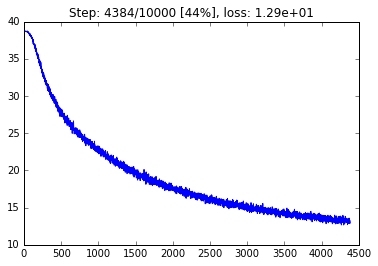

CPU times: user 44min 12s, sys: 5min 57s, total: 50min 9s
Wall time: 49min 28s


In [9]:
%%time
def test_train_model(image_shape, step_num, learning_rate, embed_dims, aug_num):
    model = create_emb_model(image_shape, embed_dims, aug_num)
    model.train(step_num, learning_rate)
    return model

if global_run_tests:
    _emb_model = test_train_model(
        image_shape   = [128,128,1],
        step_num      = 10000, 
        learning_rate = 1e-4,
        embed_dims    = 100,
        aug_num       = 100)

In [25]:
%%time
def save_model(model, path):
    pass
    # saver = tf.train.Saver()
    # saver.save(model._session, path)

def restore_model(image_shape, embed_dims, aug_num, model_path):
    model = create_model(image_shape, embed_dims, aug_num)
    saver = tf.train.Saver(var_list=tf.get_collection(key=tf.GraphKeys.GLOBAL_VARIABLES))
    saver.restore(model._session, path)
    
if global_run_tests:
    save_model(_emb_model, "data/embedding_model.ckpt")

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 19.3 µs


## Test embedding

In [105]:
%%time
def test_build_database(model, images, aug_num, aug_rate):
    assert model, "Model is not defined"
    augment         = Augmentator().augment
    data_size       = len(images)
    database_images = np.repeat(images, aug_num, axis=0)
    indecies = np.repeat(np.arange(data_size), aug_num, axis=0)
    for i in range(len(database_images)):
        if i% 10 == 0:
            clear_output(True)
            print("Augmentation: %d / %d" % (i//aug_num+1, data_size))
        database_images[i] = augment(database_images[i], use_cache = False, rate=aug_rate)

    print("Embedding ...")
    embeddings = model.embed_images(database_images)

    print("Building KDTree ...")
    tree = spatial.KDTree(embeddings)

    print("aug num   :", aug_num)
    print("aug rate  : %.1f" % aug_rate)
    print("images    :", list(images.shape))
    print("embeddings:", list(embeddings.shape))
    print("indecies  :", list(indecies.shape))
    return images, embeddings, indecies, tree

if global_run_tests:
    _emb_database = test_build_database(
        model    = _emb_model, 
        images   = _emb_model.data.test_images,
        aug_num  = 10,
        aug_rate = 1.)

Augmentation: 1000 / 1000
Embedding ...
Building KDTree ...
aug num   : 10
aug rate  : 1.0
images    : [1000, 128, 128, 1]
embeddings: [10000, 100]
indecies  : [10000]
CPU times: user 1min 23s, sys: 1.26 s, total: 1min 25s
Wall time: 1min 23s


In [ ]:
%%time
def find_nearest(tree, targets):
    results = tree.query(targets)
    return results[1], results[0]

def show_results(targets, nearest, num):
    _,h,w,_ = targets.shape
    img1 = targets.reshape([num*h,w])
    img2 = nearest.reshape([num*h,w])
    img1[:,0]   = 0
    img2[:,w-1] = 0
    sheet = np.concatenate([img1, img2], axis=1)
    sheet[np.arange(0,h*num,h)-1,:] = 0
    sheet[np.arange(0,h*num,h)+1,:] = 0
    cols = 6
    show_images(images=sheet, image_shape=[h, 2*w], cols=cols, rows=num//cols)

def test_search_images(model, database, images, num, aug_rate):
    assert model,    "Model is not defined"
    assert database, "Database is not defined"
    
    database_img, database_emb, database_idx, tree = database    
    augment   = Augmentator().augment
    
    per = np.arange(len(images))
    np.random.shuffle(per)
    target_idx = per[:num]
    
    target_images = np.copy(images[target_idx])

    print("augmentation ...")
    for i in range(len(target_images)):
        target_images[i] = augment(target_images[i], use_cache = False, rate=aug_rate)
    
    print("embedding ...")
    targets_emb = model.embed_images(target_images)

    print("searching ...")
    nearest_idx, distances = find_nearest(tree, targets_emb)
    original_idx   = database_idx[nearest_idx]
    nearest_images = database_img[original_idx]
    
    quality = np.sum(original_idx == target_idx) / len(target_idx) * 100
    
    print("database:", list(database_emb.shape))
    print("targets :", list(targets_emb.shape))
    print("aug rate: %.1f" % aug_rate)
    print("quality : %.1f%%" % quality)
    show_results(target_images, nearest_images, num)

if global_run_tests:
    test_search_images(
        model    = _emb_model, 
        database = _emb_database,
        images   = _emb_model.data.test_images,
        aug_rate = .5,
        num      = 500)

augmentation ...
embedding ...
searching ...
